In [1]:
import json
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle

import numpy as np
from stl import mesh
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, Polygon

In [2]:
from SR_code.generate_line_segments_dynamic_thickness import *

Save out STL

In [3]:

# Function to convert 2D polygon to 3D mesh by adding thickness
def polygon_to_3d_mesh(polygon, thickness=1.0):
    # Get the exterior coordinates of the 2D polygon
    exterior_coords = list(polygon.exterior.coords)
    
    # Create vertices for the top and bottom of the 3D shape
    top_vertices = [(x, y, thickness) for x, y in exterior_coords]
    bottom_vertices = [(x, y, 0) for x, y in exterior_coords]
    
    # Vertices array: two sets of vertices (top and bottom)
    vertices = np.array(top_vertices + bottom_vertices)
    
    # Number of points in the polygon
    n = len(exterior_coords)
    
    # Create faces (triangles) connecting the top and bottom surfaces
    faces = []
    
    # Create side walls
    for i in range(n):
        next_i = (i + 1) % n
        faces.append([i, next_i, n + next_i])   # Top to bottom
        faces.append([i, n + next_i, n + i])    # Bottom to top
    
    # Create top and bottom surfaces
    for i in range(1, n - 1):
        faces.append([0, i+1, i ])#[0, i, i + 1])             # Top face
        faces.append([n, n + i, n + i+1]) #[n, n + i, n + i + 1])     # Bottom face

    # Convert faces to NumPy array
    faces = np.array(faces)
    
    # Create mesh object
    polygon_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    
    for i, face in enumerate(faces):
        for j in range(3):
            polygon_mesh.vectors[i][j] = vertices[face[j], :]
    
    return polygon_mesh

def merge_3d_meshes(mesh_list):
    # List to hold the vertices and faces of the merged mesh
    vertices = []
    faces = []
    
    # Variable to track the current offset for the face indices
    vertex_offset = 0
    
    # Iterate over each mesh and extract its vertices and faces
    for m in mesh_list:
        # Extract the vertices and faces of the current mesh
        current_vertices = m.vectors.reshape(-1, 3)  # Each face is a set of 3 vertices
        current_faces = np.arange(len(current_vertices)).reshape(-1, 3)
        
        # Append the vertices, and adjust the face indices by the current offset
        vertices.append(current_vertices)
        faces.append(current_faces + vertex_offset)
        
        # Update the vertex offset for the next mesh
        vertex_offset += len(current_vertices)
    
    # Concatenate all the vertices and faces into a single array
    vertices = np.vstack(vertices)
    faces = np.vstack(faces)
    
    # Create a new merged mesh
    merged_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    
    # Fill the new mesh with the vertices and faces
    for i, face in enumerate(faces):
        for j in range(3):
            merged_mesh.vectors[i][j] = vertices[face[j], :]
    
    return merged_mesh

def save_stl(poly_dict, out_plane_thickness, name, f_x=1, f_y = 1, frame_thickness = None):
    mesh_list = []
    for k,v in poly_dict.items():
        p = [] 
        for j in v:
            try: 
                p.append((float(j[0]), float(j[1])))
            except:
                None
        
        mesh_list.append(polygon_to_3d_mesh(Polygon(p), thickness=out_plane_thickness))
    
    if frame_thickness != None:
        t = frame_thickness
        bottom = Polygon([ (0,0-t), (0,0),(f_x,0),(f_x,0-t)])
        top = Polygon([(0,f_y),(0,f_y+t), (f_x,f_y+t), (f_x,f_y)])
        right = Polygon([(f_x,0-t), (f_x,f_y+t), (f_x+t,f_y+t), (f_x+t,0-t)])
        left = Polygon([(0-t,0-t),(0-t,f_y+t), (0,f_y+t), (0,0-t)])

        f = [bottom,top]#,  right, left]

        for f_ in f:            
            mesh_list.append(polygon_to_3d_mesh(f_, thickness=out_plane_thickness))

    merged_mesh = merge_3d_meshes(mesh_list)

    # Save the merged mesh as an STL file   
    merged_mesh.save(name)

Configurations

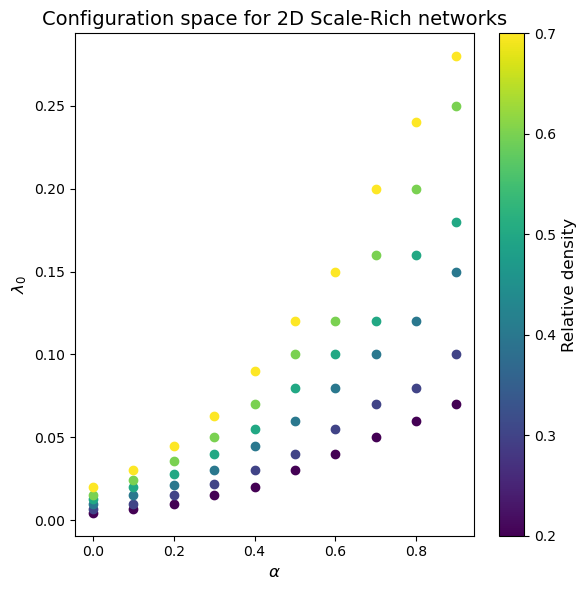

In [ ]:
#alpha:[lambda_0, density]
conf_dict ={0: [(0.0044,0.2),(0.0065,0.3),(0.01,0.4),(0.0125,0.5),(0.015,0.6),(0.02,0.7)],
 .1: [(0.007,0.2),(0.01,0.3),(0.015,0.4),(0.02,0.5),(0.024,0.6),(0.03,0.7)],
 .2: [(0.01,0.2),(0.015,0.3),(0.021,0.4),(0.028,0.5),(0.036,0.6),(0.045,0.7)],
 .3: [(0.015,0.2),(0.022,0.3),(0.03,0.4),(0.04,0.5),(0.05,0.6),(0.063,0.7)],
 .4: [(0.02,0.2),(0.03,0.3),(0.045,0.4),(0.055,0.5),(0.07,0.6),(0.09,0.7)],
 .5: [(0.03,0.2),(0.04,0.3),(0.06,0.4),(0.08,0.5),(0.1,0.6),(0.12,0.7)],
 .6: [(0.04,0.2),(0.055,0.3),(0.08,0.4),(0.1,0.5),(0.12,0.6),(0.15,0.7)],
 .7: [(0.05,0.2),(0.07,0.3),(0.1,0.4),(0.12,0.5),(0.16,0.6),(0.2,0.7)],
 .8: [(0.06,0.2),(0.08,0.3),(0.12,0.4),(0.16,0.5),(0.2,0.6),(0.24,0.7)],
  .9: [(0.07,0.2),(0.1,0.3),(0.15,0.4),(0.18,0.5),(0.25,0.6),(0.28,0.7)]}

plt.figure(figsize=(6,6))

for alpha, pairs in conf_dict.items():
    for lambda0, density in pairs:
        plt.scatter(alpha, lambda0, c=density,
                    vmin=0.2, vmax=0.7, cmap='viridis')

plt.xlabel(r'$\alpha$', fontsize=12)
plt.ylabel(r'$\lambda_0$', fontsize=12)
plt.title('Configuration space for 2D Scale-Rich networks', fontsize=14)

cbar = plt.colorbar()
cbar.set_label('Relative density', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
from shapely.geometry import Point, LineString, Polygon

#size
size = 500
path = './'

for r in [1,2,]:#,2,3]:
    #for a,l0_list in conf_dict.items():
    for a in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        for l0, den in conf_dict[a]:
            
            l = [l0*(t)**(-a) for t in range(1, size+1)]
            ang = [random.uniform(0, 2*math.pi) for t in range(1, size+1)]
            segment_dict, polygon_arr, segment_thickness_dict, random_pts_ang = generate_line_segments_dynamic_thickness(size = len(l),
                                                                                   thickness_arr =  l, epsilon= 0.03,
                                                                                   angles = ang,
                                                                                   box_size=1)
            
            area = np.sum([v.area() for k,v in segment_thickness_dict.items()])
            avg_thickness = np.round(np.mean(l), 4)
            
            thickness_string = str(round(l0,4)).replace(r'.', r'p')
            name = 'sample_ScaleRich_r0_l'+thickness_string+'_a'+str(int(a*10000))+'_v'+str(r)+'_d'+str(int(area*100))

            
            #save the output to a pickle file
            output_file = { 'segment_dict': segment_dict,
                            'polygon_arr': polygon_arr,
                            'segment_thickness_dict': segment_thickness_dict,
                            'config': random_pts_ang,
                            'avg_thickness': avg_thickness,
                            'l0': l0,
                            'a': a,
                            'area': area}
            
            with open(path+name+'.pkl', 'wb') as f:
                pickle.dump(output_file, f)

            #make sure the system is connected
            elements_to_remove = []
            for i in range(1,  int((len(segment_dict)-4)/2) +1):
                neighbours_list = list(segment_dict[f'{str(i)}_1'].neighbors.keys()) + list(segment_dict[f'{str(i)}_2'].neighbors.keys())
                #check if all elements of the list have 'b' in them
                if all([x[0] == 'b' for x in neighbours_list]):
                    elements_to_remove.append(i)

            polygon_dict = {}
            for key,val in segment_thickness_dict.items():
                if key not in elements_to_remove:
                    v_list = val.vertices
                    v_list += [(val.vertices[0])]
                    polygon_dict[key] = [[float(i[0]), float(i[1])] for i in v_list]

            #save the polygon_dict to a pickle file
                    
            with open(path+'input_'+ name+ '.pkl', 'wb') as f:
                pickle.dump(polygon_dict, f, protocol=2)

            #save the structure in an stl file
            save_stl(poly_dict=polygon_dict, out_plane_thickness = 0.25, name=path+name+'.stl', frame_thickness=None)

No valid location found% done
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No valid location found
trial
No v

KeyboardInterrupt: 